In [80]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [65]:
df_movies = pd.read_csv('/content/movies.csv')
df_ratings = pd.read_csv('/content/ratings.csv')

In [66]:
df_ratings = df_ratings.groupby('movieId')['rating'].mean()

In [67]:
df = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [68]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10325 entries, 0 to 10324
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  10325 non-null  int64  
 1   title    10325 non-null  object 
 2   genres   10325 non-null  object 
 3   rating   10325 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 322.8+ KB
None


In [69]:
df.head()

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.907328
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.353261
2,3,Grumpier Old Men (1995),Comedy|Romance,3.189655
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.818182
4,5,Father of the Bride Part II (1995),Comedy,3.250000


In [70]:
genres_one_hot = df['genres'].str.get_dummies(sep='|')
df = pd.concat([df, genres_one_hot], axis=1)
df.drop('genres', axis=1, inplace=True)
df.drop('(no genres listed)', axis=1, inplace=True)

In [71]:
df.head()

,movieId,title,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),3.907328,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),3.353261,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),3.189655,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),2.818182,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),3.250000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


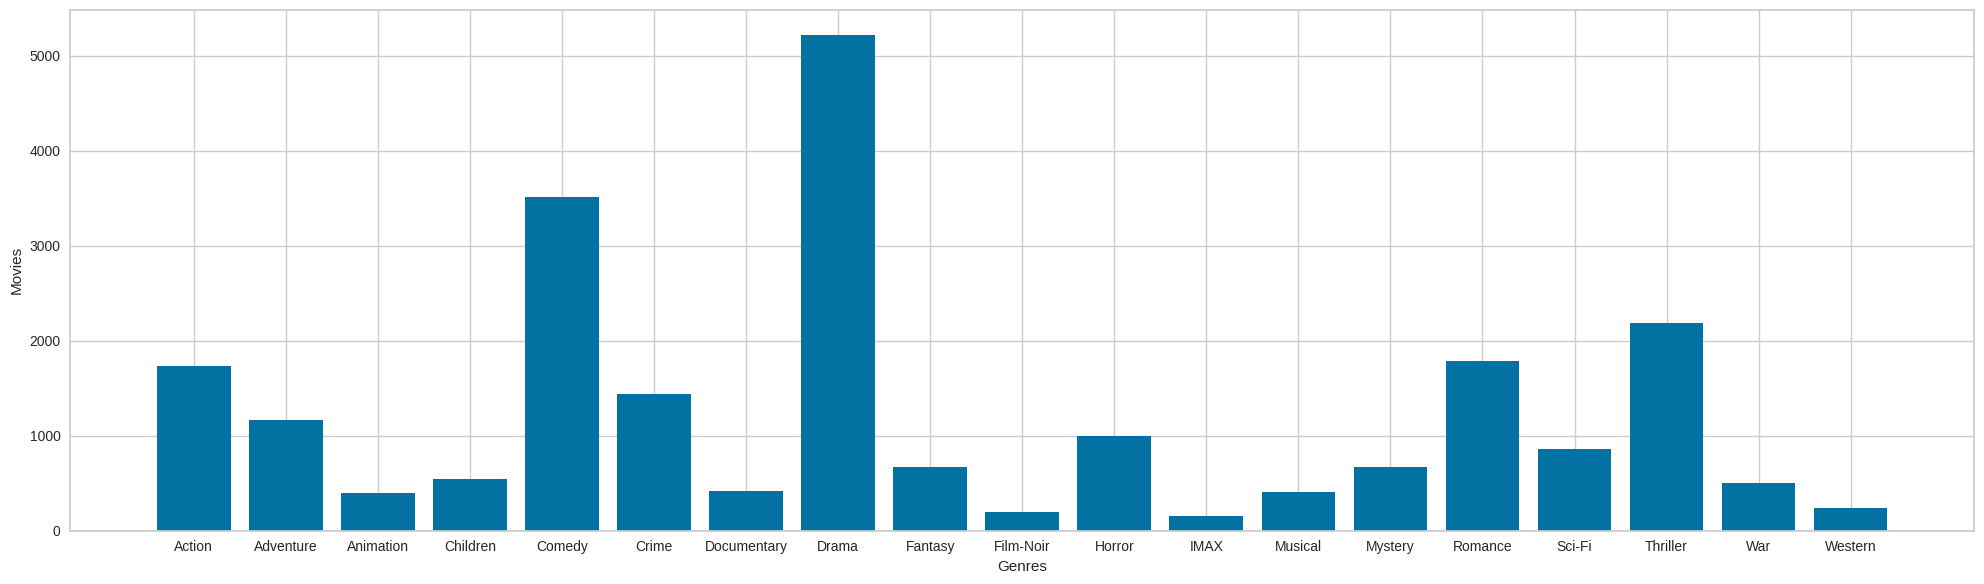

In [91]:
genre_counts = df.iloc[:, 3:].sum(axis=0)
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(genre_counts.index, genre_counts.values)
ax.set_xlabel('Genres')
ax.set_ylabel('Movies')
plt.tight_layout()
plt.show()

In [101]:
def get_recommendations_from_genres(genres, threshold_rating = 4.0):
    df_filtered = df[df[genres].apply(lambda x: any(x), axis=1)]
    df_recommendations = df_filtered[df_filtered['rating'] >= threshold_rating]
    df_recommendations = df_recommendations.sort_values(by='rating', ascending=False)
    return df_recommendations

def one_hot_to_genres(row):
    genre_columns = df.iloc[:, 3:].columns
    genres = []
    for genre in genre_columns:
        if row[genre] == 1:
            genres.append(genre)
    return '|'.join(genres)

def convert_df(df):
    genre_columns = df.iloc[:, 3:].columns

    def one_hot_to_genres(row):
        genres = []
        for genre in genre_columns:
            if row[genre] == 1:
                genres.append(genre)
        return '|'.join(genres)

    df['genres'] = df.apply(one_hot_to_genres, axis=1)
    df = df.drop(columns=genre_columns)

    return df

In [103]:
input_genres = ['Comedy', 'Romance']
rec = get_recommendations_from_genres(input_genres)
convert_df(rec.head(5))

<ipython-input-101-5a911cd4670c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres'] = df.apply(one_hot_to_genres, axis=1)


,movieId,title,rating,genres
10171,127052,Operation 'Y' & Other Shurik's Adventures (1965),5.0,Comedy|Crime|Romance
9085,89045,Rocky VI (1986),5.0,Comedy
9426,96467,Sleepwalk with Me (2012),5.0,Comedy|Drama
1495,1925,Wings (1927),5.0,Action|Drama|Romance|War
6131,26347,"Irony of Fate, or Enjoy Your Bath! (Ironiya su...",5.0,Comedy|Drama|Romance


In [106]:
genre_matrix = df.iloc[:, 3:].values
linear_sim = linear_kernel(genre_matrix, genre_matrix)
indices = pd.Series(df.index, index=df['title']).drop_duplicates()
def get_recommendations_from_name(title, linear_sim=linear_sim):
    idx = indices[title]
    sim_scores = list(enumerate(linear_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices]

In [118]:
random_title = df['title'].sample().values[0]
recommendations = get_recommendations_from_name(random_title)
print('Movie title: ',random_title)
print('recommendations movies:\n',recommendations)

Movie title:  Mute Witness (1994)
recommendations movies:
 158                                 Mute Witness (1994)
655                             Frighteners, The (1996)
1071             American Werewolf in London, An (1981)
1143                                      Scream (1996)
1365                                    Scream 2 (1997)
1556                              Child's Play 3 (1991)
1831            Bride of Chucky (Child's Play 4) (1998)
1968    Leatherface: Texas Chainsaw Massacre III (1990)
2090                                  Mummy, The (1999)
2234              American Werewolf in Paris, An (1997)
Name: title, dtype: object
